Находим фичи, которые можно рпеобразовать в 0/1 >0 <0

In [313]:
import pandas as pd
import random
import numpy as np
import seaborn as sns
import math
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import scipy
from statsmodels.stats.weightstats import *
from sklearn import cross_validation, datasets, linear_model, metrics
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic
import matplotlib.pyplot as plt
from scipy.stats import norm,t

In [13]:
X=pd.read_csv('x_train.csv',delimiter=";",header=None,names=['f'+str(i) for i in range (223)])
X_test=pd.read_csv('x_test.csv',delimiter=";",header=None,names=['f'+str(i) for i in range (223)])
y=pd.read_csv('y_train.csv',names=['class'])
y=y['class']
data=X.join(y)

In [206]:
X_ftr=pd.read_csv('ftr_train.csv')
X_ftr.drop('Unnamed: 0',inplace=True,axis=1)

In [162]:
# 
def get_ci(data,ftr,plot_gr=True):
    mean_list=list()
    ci_1_list=list()
    ci_2_list=list()
    sign_list=list()
    x=np.arange(5)
    for cl in range(5):
        cl_data=data[data['class']==cl][ftr]
        n=len(cl_data)
        mean=cl_data.mean()
        mean_list.append(mean)
        std = cl_data.std(ddof=1)/np.sqrt(n)
        ci= _tconfint_generic(mean, std,n - 1,0.05, 'two-sided')
        ci_1=ci[0]
        ci_2=ci[1]
        if (ci_1<0)&(ci_2<0): 
            ci_sign=-1
        elif (ci_1>0)&(ci_2>0): ci_sign=1
        else: ci_sign=0
        ci_1_list.append(mean-ci_1)
        ci_2_list.append(ci_2-mean)
        #print ("mean {} ci {} {}".format(mean,ci,ci_sign))
        sign_list.append(ci_sign)
    if plot_gr:
        plt.errorbar(x=x, y=mean_list,yerr=[ci_1_list,ci_2_list])
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title(ftr)
        plt.show()
    return abs(np.sum(sign_list)*abs(np.prod(sign_list)))
#scipy.stats.ttest_ind(data.Plbacebo, data.Methylphenidate, equal_var = False)

In [165]:
int_ftr=list()
for col in X.columns:
    if get_ci(data,col,False)==1:
        #get_ci(data,col,True)
        int_ftr.append(col)



In [169]:
print (int_ftr)

['f11', 'f18', 'f27', 'f63', 'f72', 'f98', 'f108', 'f112', 'f114', 'f138', 'f168', 'f170', 'f171', 'f179', 'f188', 'f205', 'f213']


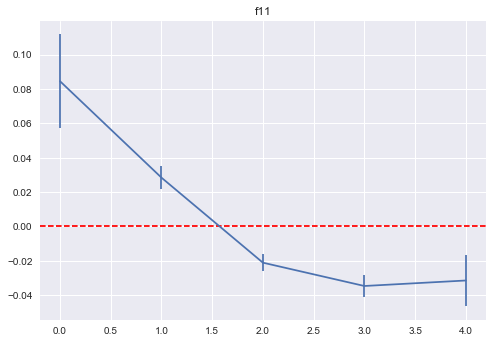

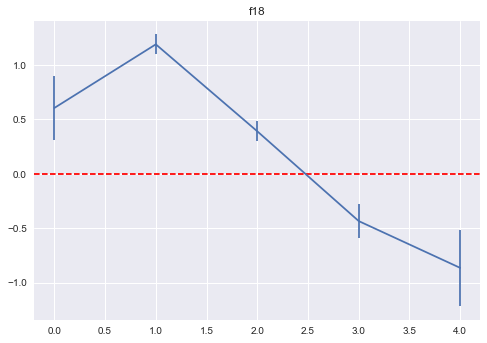

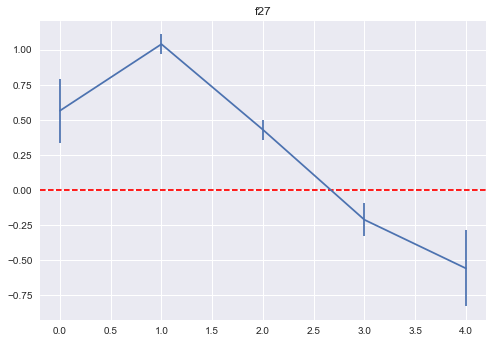

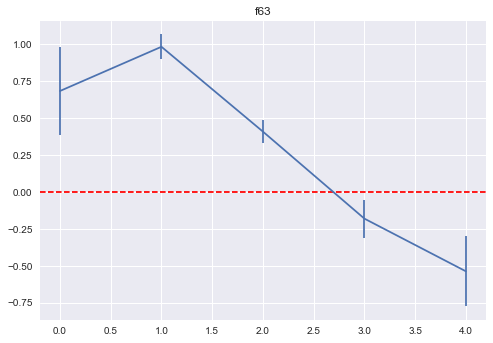

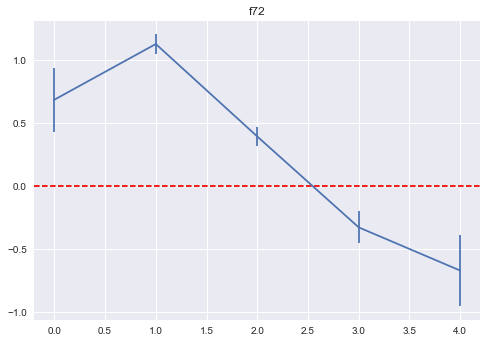

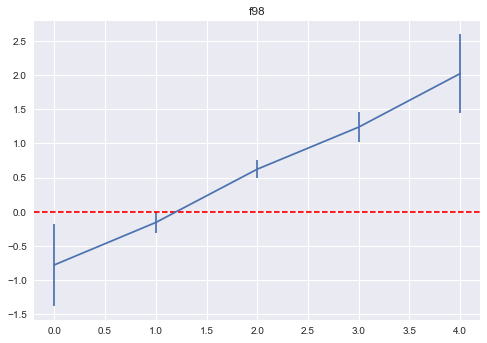

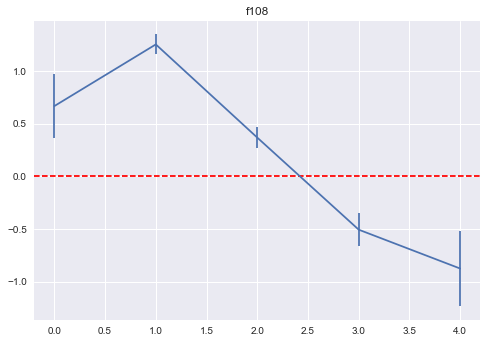

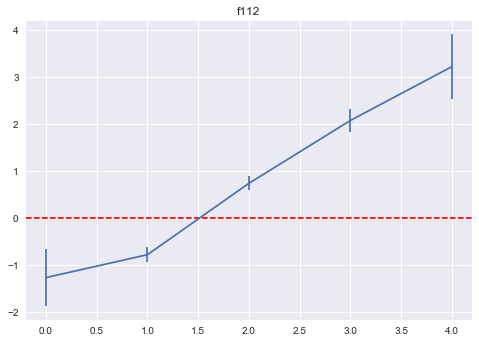

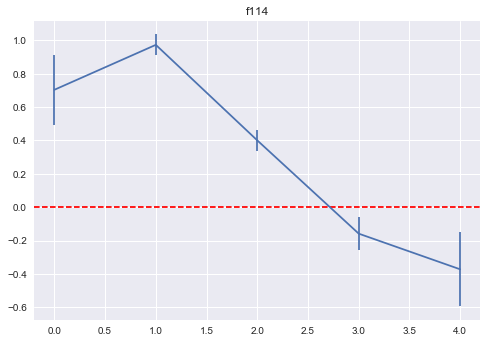

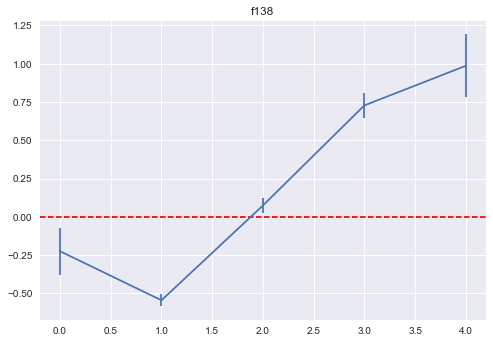

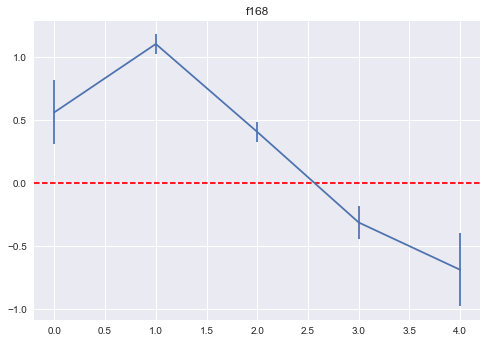

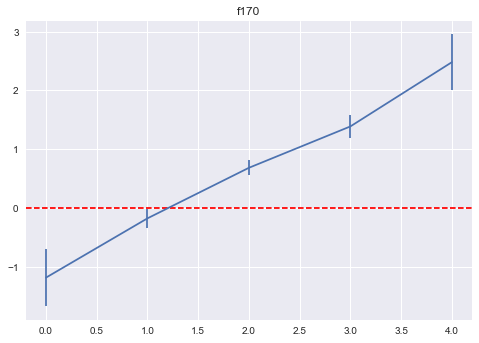

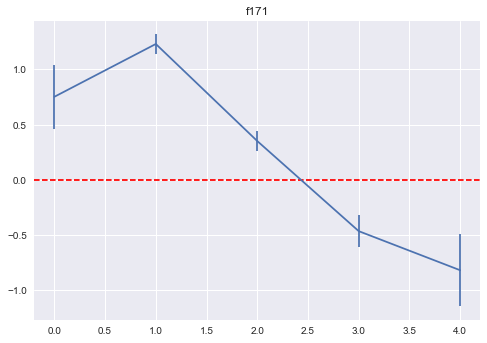

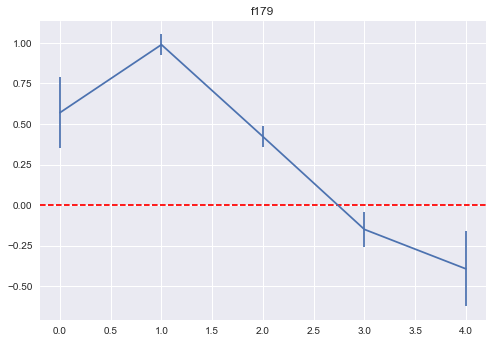

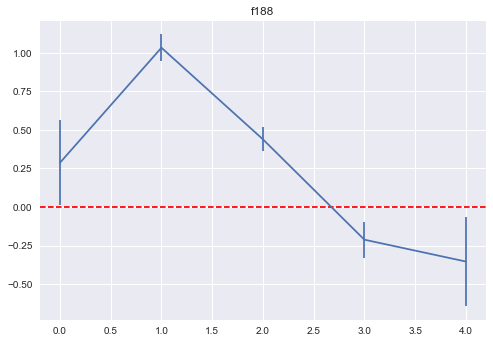

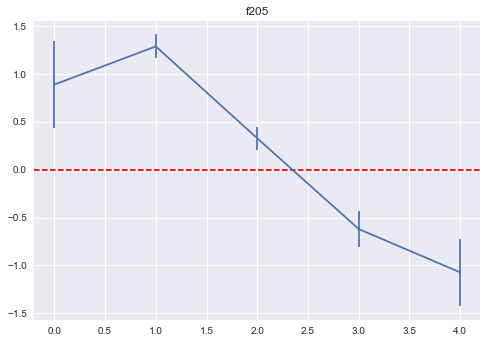

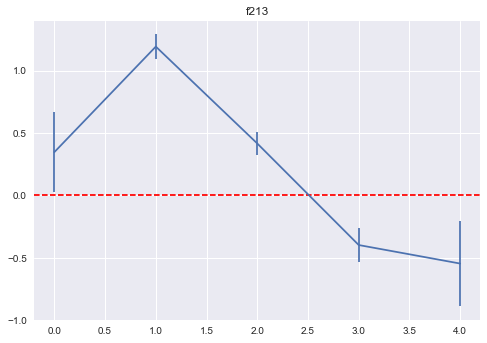

In [167]:
for col in int_ftr:
    get_ci(data,col,True) 

Добавляем в X новые признаки - boolean

In [207]:
cols=['f11', 'f18', 'f27', 'f63', 'f72', 'f98', 'f108', 'f112', 'f114', 'f138', 'f168', 'f170', 'f171', 'f179', 'f188', 'f205', 'f213']
for c in cols:
    X_ftr['b'+c]=(X_ftr[c]>0)*1

In [212]:
# Проверка на несовпадение средних

In [277]:
def get_ci_1(data,ftr,plot_gr=True,p=0.05):
    mean_list=list()
    ci_1_list=list()
    ci_2_list=list()
    sign_list=list()
    ci_list=list()
    k=0
    x=np.arange(5)
    for cl in range(5):
        cl_data=data[data['class']==cl][ftr]
        n=len(cl_data)
        mean=cl_data.mean()
        mean_list.append(mean)
        std = cl_data.std(ddof=1)/np.sqrt(n)
        ci= _tconfint_generic(mean, std,n - 1,0.05, 'two-sided')
        ci_list.append(ci)
        ci_1=ci[0]
        ci_2=ci[1]
        ci_1_list.append(mean-ci_1)
        ci_2_list.append(ci_2-mean)
    if plot_gr:
        plt.errorbar(x=x, y=mean_list,yerr=[ci_1_list,ci_2_list])
        plt.axhline(y=0, color='r', linestyle='--')
        plt.title(ftr)
        plt.show()
    for c1 in range(5):
        for c2 in range(5):
            if c1<=c2:
                continue
            cl_data1=data[data['class']==c1][ftr]
            cl_data2=data[data['class']==c2][ftr]
            t=scipy.stats.ttest_ind(cl_data1, cl_data2, equal_var = False)
            if t[1]>p:
                k=k+1
                if plot_gr:
                    print (c1,c2)
    return k,ci_list
#scipy.stats.ttest_ind(data.Plbacebo, data.Methylphenidate, equal_var = False)

In [326]:
#get_ci_1(data,'f1',True,p=0.01)
my_list=list()
for col in int_ftr:
    t,ci=get_ci_1(data,col,False) 
    if t<=1:
        my_list.append([col,ci])
        print (col)
        #get_ci_1(data,col,True) 

f18
f27
f72
f98
f112
f114
f138
f168
f170
f171
f205


In [299]:
data[['f18','class']].head()

,f18,class
0,3.988655,2
1,-2.373294,3
2,-0.631464,2
3,1.918863,1
4,-0.320227,2


In [306]:
y.shape

(3489,)

0.092064426050776804

In [297]:
def get_new(i):
    ftr=i[0]
    ci=i[1]
    print ("ftr:",ftr,"ci",ci)
    for row in X[ftr]:
        class_n=0
        class_=-1
        for c in ci:
            if (row>=c[0])&(row<=c[1]):
                class_=class_n
            class_n=class_n+1
        print (row,class_)

#for i in my_list:
#    get_new(i)
get_new(my_list[0])    

ftr: f18 ci [(0.30963694370548117, 0.9013691945246074), (1.0994060118658926, 1.2818877238729389), (0.29828386323442924, 0.48330653404367685), (-0.58788988506266182, -0.28196637934353475), (-1.2179517261578989, -0.51283889602391963)]
3.98865499 -1
-2.37329354 -1
-0.63146414 4
1.91886306 -1
-0.32022657 3
1.99427924 -1
2.42549304 -1
-0.95906425 4
1.36801594 -1
2.35151283 -1
-0.45893144 3
-0.47366714 3
1.89141881 -1
-0.90041065 4
-0.28060754 -1
-1.52542858 -1
3.49067549 -1
-0.6797621 4
0.70011617 0
-0.40282119 3
4.10625933 -1
-0.010068 -1
-1.13118752 4
-1.31148403 -1
3.43926452 -1
-0.06107807 -1
1.06632429 -1
-0.34455185 3
3.29900568 -1
2.42906085 -1
-1.42065097 -1
-1.41496084 -1
-1.1011502 4
1.55796806 -1
-1.50646909 -1
-1.3196273 -1
1.51523525 -1
0.72565246 0
2.58359805 -1
2.42355691 -1
-1.1418473 4
1.21700557 1
0.4569487 2
-2.42679225 -1
-2.59705862 -1
0.81441795 0
1.27857814 1
1.13619649 1
-1.91824661 -1
3.43761395 -1
2.08622763 -1
-1.43852883 -1
-1.25405225 -1
-1.99341473 -1
-1.439526

In [266]:
for c in range(5):
    print (c,data[data['class']==c]['f170'].mean())

#data['class']==5

0 -1.1830996427433624
1 -0.17487741292955297
2 0.6849819947074294
3 1.3887048991738384
4 2.4808686020909083


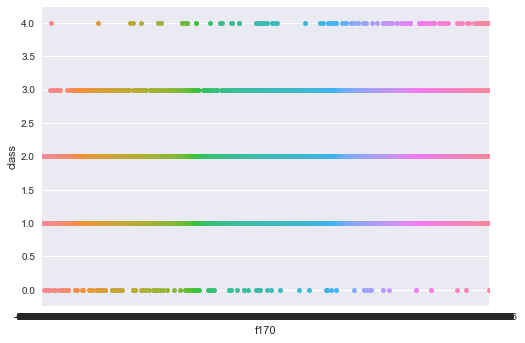

In [262]:
sns.stripplot(x="f170", y="class", data=data);
plt.show()

In [184]:


rf=RandomForestClassifier(max_features='auto',n_estimators=300,max_depth=100,random_state=42)
best_cols=['f138', 'f96', 'f76', 'f11', 'f185', 'f115', 'f131']
print (np.mean(cross_val_score(rf, X[best_cols], y, cv=5)))

0.632562811448


In [211]:
rf=RandomForestClassifier(max_features='auto',n_estimators=300,max_depth=100,random_state=42)
best_cols=['f138', 'f96', 'f76', 'f11', 'f185', 'f115', 'f131', 'f83', 'bf11']
print (np.mean(cross_val_score(rf, X[best_cols], y, cv=5)))
# 0.636874370739 f83
# 0.634868623603 /f83


0.636874370739


# Обучаем регрессию на фиче

In [324]:
X1=X[['f98']]
y1=y
clf=RandomForestClassifier(n_estimators=60,)
clf.fit(X1,y1)
clf.score(X1,y1)

0.99770707939237602

In [321]:
my_list

[['f18',
  [(0.30963694370548117, 0.9013691945246074),
   (1.0994060118658926, 1.2818877238729389),
   (0.29828386323442924, 0.48330653404367685),
   (-0.58788988506266182, -0.28196637934353475),
   (-1.2179517261578989, -0.51283889602391963)]],
 ['f27',
  [(0.33589386781284392, 0.79322484422255435),
   (0.96893875521450157, 1.1077070187717517),
   (0.35746248449472523, 0.50074685066635427),
   (-0.3297187435329631, -0.094746047861184735),
   (-0.82807006484263912, -0.28814872188463397)]],
 ['f72',
  [(0.43313476055679234, 0.93969505448745605),
   (1.0523103334356352, 1.2045945253959809),
   (0.31672904926538981, 0.47229278304230271),
   (-0.45461434574338261, -0.19875888479018039),
   (-0.95227245182921538, -0.38611789107987532)]],
 ['f98',
  [(-1.3863514056234503, -0.17447691561548784),
   (-0.31146522081778094, -0.0054235116564462227),
   (0.49186623328994372, 0.75400749859697069),
   (1.0250702793648399, 1.4540344287590818),
   (1.4503211194025543, 2.5984625127792631)]],
 ['f112',
